# Imports

In [1]:
from helpers import *

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

from math import sqrt, pi as PI
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

# Setup

In [2]:
N_EXPERIMENTS = 5
N_STEPS = 200
N_SIMULATIONS = 200
MIN_X, MAX_X = [-10, 10]
MIN_Y, MAX_Y = [-10, 10]
N_ANCHORS = 5

In [3]:
data = RandomSimulation(N_SIMULATIONS, N_STEPS, MIN_X, MIN_Y, MAX_X, MAX_Y, N_ANCHORS)

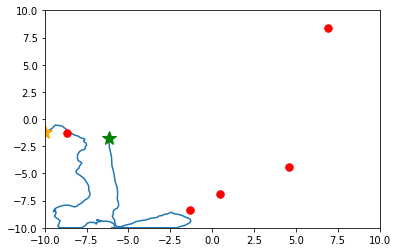

In [4]:
data.plot_simulation(data[0][1])

In [5]:
train_loader, test_loader = data.get_random_loaders(0.8, 1)

In [6]:
criterion = nn.MSELoss()

def train_encoder(model, train_loader, test_loader, nb_epochs):
    """Train a model"""
    
    optimizer = Adam(model.parameters())
    train_losses = []
    test_losses = []

    for _ in range(nb_epochs):
        losses = []
        for batch_input, _ in train_loader:
            output = model(batch_input.view(-1, batch_input.size(-1)))
            loss = criterion(output, batch_input.view(-1, batch_input.size(-1)))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        train_losses.append(torch.Tensor(losses).mean().item())
            
        losses = []
        for batch_input, _ in test_loader:
            output = model(batch_input.view(-1, batch_input.size(-1)))
            loss = criterion(output, batch_input.view(-1, batch_input.size(-1)))
            losses.append(loss.item())
        test_losses.append(torch.Tensor(losses).mean().item())
        
    return train_losses, test_losses

In [7]:
def plot_loss_evolution(train_losses, test_losses):
    plt.plot(train_losses, c='blue')
    plt.plot(test_losses, c='orange')
    plt.legend(['train loss', 'test loss'])
    plt.ylim(0, 200)
    plt.grid();

In [8]:
N_EPOCHS = 500

### ReLU

In [9]:
%%time

dims = [2,3,4,5,6]
n_hidden_units = 12
n_dims = len(dims)
results_relu = {}

for dim in dims:
    encoder = nn.Sequential(
        nn.Linear(3 * N_ANCHORS, n_hidden_units), nn.ReLU(),
        nn.Linear(n_hidden_units, dim)
    )

    decoder = nn.Sequential(
        nn.Linear(dim, n_hidden_units), nn.ReLU(),
        nn.Linear(n_hidden_units, 3 * N_ANCHORS)
    )

    model = nn.Sequential(
        encoder,
        decoder
    )
    
    train_losses, test_losses = train_encoder(model, train_loader, test_loader, N_EPOCHS)
    
    results_relu[dim] = {
        'model': model,
        'train_losses': train_losses,
        'test_losses': test_losses
    }

CPU times: user 4min 45s, sys: 2.16 s, total: 4min 47s
Wall time: 4min 46s


In [ ]:
for dim in dims:
    # TODO

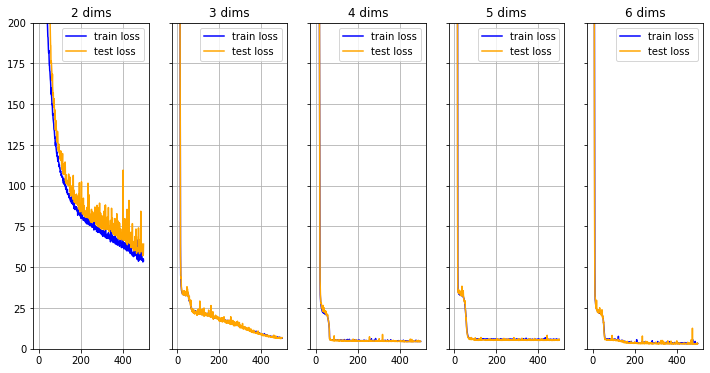

In [10]:
fig, ax = plt.subplots(nrows=(n_dims - 1) // 5 + 1, ncols=5, sharex=True, sharey=True, figsize=(12, 6))
plt.grid()

for i in range(n_dims):
    dim = dims[i]
    
    ax[i % 5].grid()
    ax[i % 5].plot()
    ax[i % 5].plot(results_relu[dim]['train_losses'], c='blue')
    ax[i % 5].plot(results_relu[dim]['test_losses'], c='orange')
    ax[i % 5].legend(['train loss', 'test loss'])
    ax[i % 5].set_title(f'{dim} dims')
    
plt.ylim(0, 200);

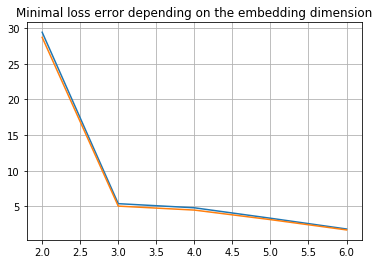

In [52]:
min_losses = {dim: [min(results_relu[dim]['train_losses']), min(results_relu[dim]['test_losses'])] for dim in dims}

plt.title('Minimal loss error depending on the embedding dimension')
plt.grid()
plt.plot(dims, [min_losses[dim][0] for dim in dims])
plt.plot(dims, [min_losses[dim][1] for dim in dims]);

CPU times: user 9min 21s, sys: 8.32 s, total: 9min 29s
Wall time: 9min 28s


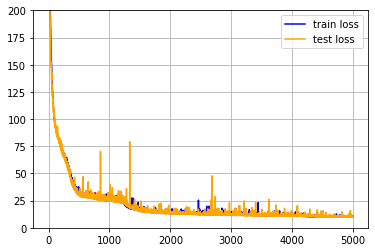

In [68]:
%%time

encoder = nn.Sequential(
    nn.Linear(3 * N_ANCHORS, 12), nn.ReLU(),
    nn.Linear(12, 2)
)

decoder = nn.Sequential(
    nn.Linear(2, 12), nn.ReLU(),
    nn.Linear(12, 3 * N_ANCHORS)
)

model_relu_2 = nn.Sequential(
    encoder,
    decoder
)

train_losses, test_losses = train_encoder(model_relu_2, train_loader, test_loader, 10 * N_EPOCHS)
plot_loss_evolution(train_losses, test_losses)

In [69]:
encoder, _ = model_relu_2
encoded_data = encoder(data[:][0])

(-10.472138476371764, 8.8236013174057, -10.73451499938965, 8.77394371032715)

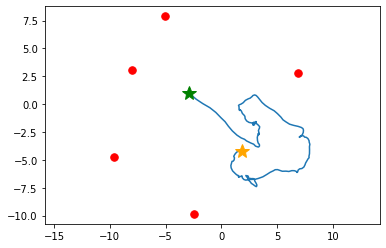

In [81]:
data.plot_simulation(data[5][1])
plt.axis("equal")

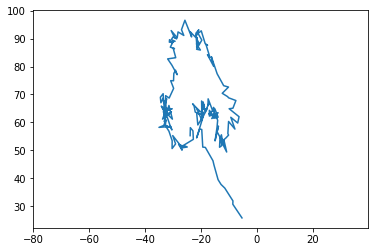

In [82]:
plt.plot(*encoded_data[5].detach().T)
plt.axis("equal");

In [63]:
from scipy.spatial.distance import pdist, squareform

In [65]:
distance_matrix_input = pdist(data[0][0].view(1 * N_STEPS, 3 * N_ANCHORS))
distance_matrix_encoded = pdist(encoded_data[0].view(1 * N_STEPS, 2).detach())

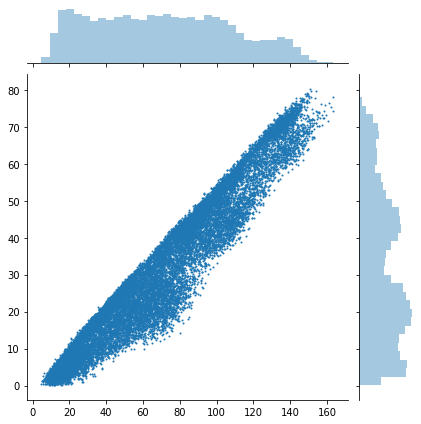

In [66]:
sns.jointplot(distance_matrix_input, distance_matrix_encoded, s=1)

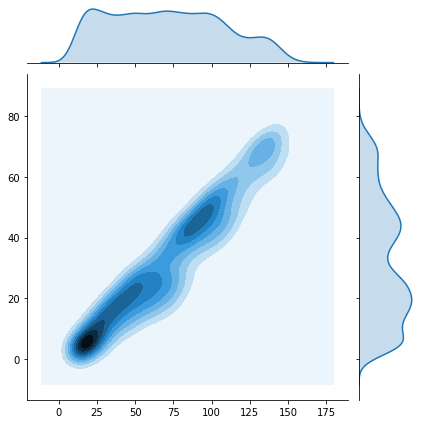

In [67]:
sns.jointplot(distance_matrix_input, distance_matrix_encoded, kind='kde')

In [56]:
np.abs(distance_matrix_encoded - distance_matrix_input)

array([17.19454125, 30.85270469, 33.00978255, ..., 23.95492696,
       21.31840386, 21.34376964])

### Tanh

In [19]:
dims = [2,3,4,5,6]
n_dims = len(dims)
results = {}

for dim in dims:
    encoder = nn.Sequential(
        nn.Linear(30, 12), nn.Tanh(),
        nn.Linear(12, dim)
    )

    decoder = nn.Sequential(
        nn.Linear(dim, 12), nn.Tanh(),
        nn.Linear(12, 30)
    )

    model = nn.Sequential(
        encoder,
        decoder
    )
    
    train_losses, test_losses = train_encoder(model, train_loader, test_loader, N_EPOCHS)
    
    results[dim] = {
        'model': model,
        'train_losses': train_losses,
        'test_losses': test_losses
    }

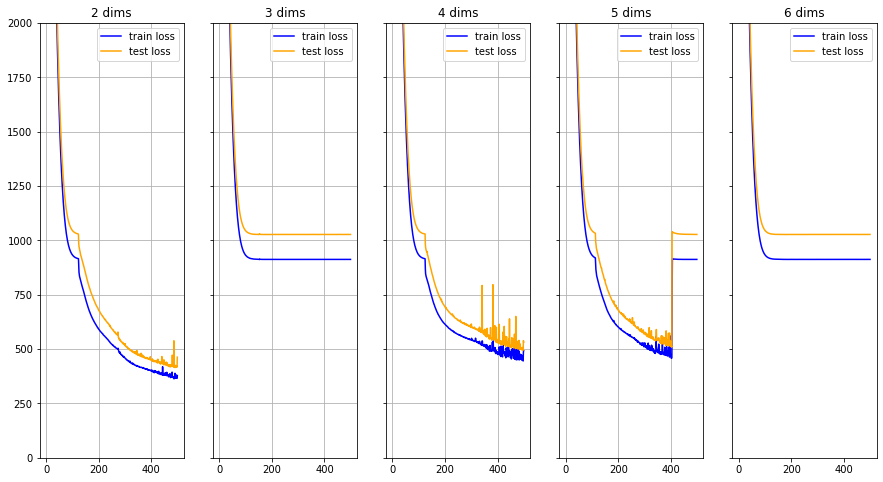

In [22]:
fig, ax = plt.subplots(nrows=(n_dims - 1) // 5 + 1, ncols=5, sharex=True, sharey=True, figsize=(15, 8))
plt.grid()

for i in range(n_dims):
    dim = dims[i]
    
    ax[i % 5].set_title(f'{dim} dims')
    ax[i % 5].plot(results[dim]['train_losses'], c='blue')
    ax[i % 5].plot(results[dim]['test_losses'], c='orange')
    ax[i % 5].grid()
    ax[i % 5].legend(['train loss', 'test loss'])
    
plt.ylim(0, 2000);

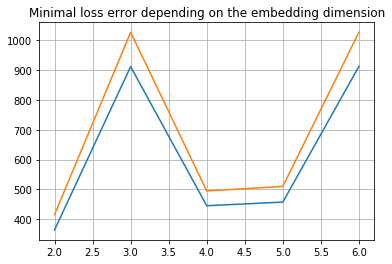

In [21]:
min_losses = {dim: [min(results[dim]['train_losses']), min(results[dim]['test_losses'])] for dim in dims}

plt.title('Minimal loss error depending on the embedding dimension')
plt.grid()
plt.plot(dims, [min_losses[dim][0] for dim in dims])
plt.plot(dims, [min_losses[dim][1] for dim in dims]);

### PCA

In [51]:
from sklearn.decomposition import PCA

In [52]:
pca = PCA(n_components=2)
pca_2D_embedding = pca.fit_transform(data[:][0].view(N_SIMULATIONS * N_STEPS, 30))

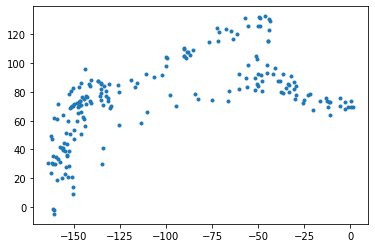

In [53]:
plt.plot(*pca_2D_embedding.reshape((N_SIMULATIONS, N_STEPS, 2))[0].T, '.')

In [54]:
pca_recovery_loss = criterion(data[:][0].view(N_SIMULATIONS * N_STEPS, 30), torch.FloatTensor(pca.inverse_transform(pca_2D_embedding)))
pca_recovery_loss

tensor(149.4587)